# erthaos-23

### README

Der Code stellt einen digitalen Assistent für die automatische Erkennung der gesuchten Motive.



Anpassbare Zeilen:

(#2) Pfad zu der eingabedatei.

(#5 und #107) Der Attributwert bestimmt die Herkunft der zu analysierenden Textgruppe (des Repertoires). Die Filter können mit den 'or' und 'and' Operatoren ergänzt werden, z. B.:  

if ('deu' in ganze.attrib['{http://www.w3.org/XML/1998/namespace}id']

    or 'ita' in ganze.attrib['{http://www.w3.org/XML/1998/namespace}id']): 

(#34) Stoppwortliste (siehe #37 mit händisch eingetragene Wortformen ergänzen).
 
(#37) Stoppwortliste für die bestimmte Sprache.
    
(#60) Anfrage anpassen. Die Werte von 'gesep_a' bis 'gesep_d' können nach der in der Motivliste ausgewälte Zeilen, oder ihre Bestandteilen ausgefült werden (#59) und anschließend in der Anfragezeile (#62) als Anfrage mit 'or' und/oder 'and' Opperatoren bestimmen.

(#78) Anzahl der Merkmale, die in der Visualisierung dargestellt werden sollen anpassen, sie darf nicht größer als gesamte Anzahl der Wörtersein (#77).

(#100) Schwelenwert anpassen. Dafür wird die Nummer des Merkmals mit minimal-positivem Koefizient gewählt (#99).
    
(#151-#161) Vorhersage durch Logistic Regression hat nur anschauliche um die Efektivität zwischen ihr und Vorhersage durch Cosine Similarity zu zeigen.

# Trainingsdaten aufbereiten und transformieren

In [218]:
maerchen = ""  #1 Eine leere Zeichenkette, in der Daten für Märchen gesammelt werden.
import xml.etree.ElementTree as ET  #2 Importieren der ElementTree-Bibliothek zum Parsen von XML.
root_node = ET.parse('gesamt_märchen.xml').getroot()  #3 Parsen der XML-Datei und Zugriff auf das Wurzelelement.
never_saved = True  #4 Ein boolean-Wert, der angibt, ob Daten bereits gespeichert wurden oder nicht.
#5 Iteration durch jedes 'text'-Element in der XML-Datei.
for corp in root_node.findall (".//{http://www.tei-c.org/ns/1.0}teiCorpus"):
    if "xtk" in corp.attrib["n"]:
        for ganze in corp.findall(".//{http://www.tei-c.org/ns/1.0}text"):
            #6 Überprüfung, ob das Attribut 'x' in der 'id'-Eigenschaft des 'text'-Elements vorhanden ist.
            if ('zyx_' in ganze.attrib['{http://www.w3.org/XML/1998/namespace}id']):
                #7 Iteration durch jeden Absatz im 'body' des 'text'-Elements.
                for body in ganze.findall(".//{http://www.tei-c.org/ns/1.0}body"):
                    for absatz in body.findall(".//{http://www.tei-c.org/ns/1.0}p"):
                        #8 Iteration durch jede 'seg'-Phrase im Absatz.
                        for phrase in absatz.findall(".//{http://www.tei-c.org/ns/1.0}seg"):
                            #9 Extrahieren von Labels und Inhalten aus den Attributen und dem Text der Phrase.
                            labela = phrase.attrib['{www.dglab.uni-jena.de/vmf/a}ana']
                            labelb1 = phrase.attrib['{www.dglab.uni-jena.de/vmf/b1}ana']
                            labelb2 = phrase.attrib['{www.dglab.uni-jena.de/vmf/b2}ana']
                            labelb3 = phrase.attrib['{www.dglab.uni-jena.de/vmf/b3}ana']
                            labelb4 = phrase.attrib['{www.dglab.uni-jena.de/vmf/b4}ana']
                            labelb5 = phrase.attrib['{www.dglab.uni-jena.de/vmf/b5}ana']
                            labelc1 = phrase.attrib['{www.dglab.uni-jena.de/vmf/c1}ana']
                            labelc2 = phrase.attrib['{www.dglab.uni-jena.de/vmf/c2}ana']
                            labelc3 = phrase.attrib['{www.dglab.uni-jena.de/vmf/c3}ana']
                            labelc4 = phrase.attrib['{www.dglab.uni-jena.de/vmf/c4}ana']
                            labelc5 = phrase.attrib['{www.dglab.uni-jena.de/vmf/c5}ana']
                            labeld = phrase.attrib['{www.dglab.uni-jena.de/vmf/d}ana']
                            #10 Die Quelle wird aus dem Attribut 'id' der 'ganze'-Schleife extrahiert.
                            quelle = ganze.attrib['{http://www.w3.org/XML/1998/namespace}id']
                            #11 Der Inhalt wird in Kleinbuchstaben umgewandelt und formatiert.
                            inhalt = (phrase.text.lower().strip().replace('|','').replace(':','').replace("ä","ae")
                                      .replace("ü","ue").replace("ö","oe").replace("ß","ss").replace(",","")
                                      .replace("«","").replace("»","").replace(".","").replace('=',' ').replace(";","")
                                      .replace('"',"").replace("?","").replace("!","").replace("á","a").replace(",","")
                                      .replace("\t"," ").replace("'","").replace("‹","").replace("›","").replace("-"," ")
                                      .replace("'('","").replace("')'","").replace('>','').replace("    "," ")
                                      .replace("   "," ").replace("  "," ").replace('–','').replace('—','').replace('<','')
                                      .replace("Â", "A").replace("ø", "oe").replace('“','').replace('„','').replace('(','')
                                      .replace(')','').replace('*','').replace("\n","\n")
                                      .replace("'''",""))
                            #12 Überprüfung, ob labela mit 'a' beginnt und nicht gleich 'N' ist.
                            if labela.startswith('a') and labelb1 != 'N':
                                    #13 Konstruktion des Datensatzes für das Märchen und Anhängen an die 'maerchen'-Zeichenkette.
                                    maerchen += (quelle+','+labela+','+labelb1+','+labelc1+','+labelb2+','+labelc2+','+
                                                 labelb3+','+labelc3+','+labelb4+','+labelc4+','+labelb5+','+labelc5+','+
                                                 labeld+','+inhalt+',0'+'\n')                       
with open("text.csv", 'w', encoding='utf-8') as f:
     #14 Schreiben der Kopfzeile in die CSV-Datei.
    f.write('quelle,labela,labelb1,labelc1,labelb2,labelc2,labelb3,labelc3,labelb4,labelc4,labelb5,labelc5,labeld,inhalt,index_binar')
    f.write('\n')
    #15 Schreiben der gesammelten Daten in die CSV-Datei.
    f.write(maerchen)

In [219]:
#15 leere Zeichenfolge, die später mit den gewünschten Daten gefüllt werden
abcd1="" 
abcd2="" 
abcd3=""  
abcd4=""  
abcd5=""  

import pandas as pd  
from collections import Counter

#16 Lesen der CSV-Datei und Laden der Daten in ein Pandas DataFrame
df = pd.read_csv('text.csv',  encoding='utf-8')

#17.1 Hinzufügen von Daten zu den entsprechenden Variablen abcd1 bis abcd5
#17.2 Hier werden die Daten aus verschiedenen Spalten des DataFrame kombiniert
abcd1 += df.quelle+','+df.labela+':'+df.labelb1+':'+df.labelc1+':'+df.labeld+':'+','+df.inhalt+',0'
abcd2 += df.quelle+','+df.labela+':'+df.labelb2+':'+df.labelc2+':'+df.labeld+':'+','+df.inhalt+',0'
abcd3 += df.quelle+','+df.labela+':'+df.labelb3+':'+df.labelc3+':'+df.labeld+':'+','+df.inhalt+',0'
abcd4 += df.quelle+','+df.labela+':'+df.labelb4+':'+df.labelc4+':'+df.labeld+':'+','+df.inhalt+',0'
abcd5 += df.quelle+','+df.labela+':'+df.labelb5+':'+df.labelc5+':'+df.labeld+':'+','+df.inhalt+',0'

#18 Zusammenführen der Daten aus den Variablen abcd1 bis abcd5
recorded=(abcd1+'\n'+abcd2+'\n'+abcd3+'\n'+abcd4+'\n'+abcd5+'\n')

#19 Schreiben der kombinierten Daten in eine neue CSV-Datei
with open("text_aw.csv", 'w', encoding='utf-8') as w:
    #20 Schreiben der Kopfzeile
    w.write('quelle,index_string,inhalt,index_binar\n')
    #21 Schreiben der vordefinierten Zeile mit Dummy-Daten
    w.write('000:ballast,ballast,ballast,0\n')
    #22 Schreiben der kombinierten Daten
    w.write("".join(recorded))
    #23 Schließen der Datei
    w.close()

In [220]:
import csv  

mom=[]  #24 Eine leere Liste zum Speichern der Zeilen, die bestimmten Kriterien entsprechen

#25 Lesen der CSV-Datei 'text_aw.csv'
with open('text_aw.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f) 
    #26 Iteration über jede Zeile in der CSV-Datei
    for line in reader:
        #27 Überprüfen, ob die Zeile nicht das Muster ':N:' in der zweiten Spalte enthält
        if ':N:' not in line[1]:
            #28 Wenn das Muster nicht vorhanden ist, wird die Zeile der Liste 'mom' hinzugefügt
            mom.append(line)

#29 Kopieren der Datei text_ax.txt
import shutil, os
with open ('text_ax.txt', 'wt', encoding='utf-8') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(mom)

#30 Öffnen der Datei text_ax.txt zum Lesen
with open('text_ax.txt', 'r', encoding='utf-8') as file:
    #31 Lesen des gesamten Inhalts der Datei
    filedata = file.read()

#32 Bearbeiten des Dateiinhalts, um das gewünschte Format zu erzielen
filedata = (filedata.replace(']","[', "\n").replace('"[','').replace(']"','')
            .replace(" '","").replace("'",""))

#33 Schreiben des bearbeiteten Inhalts in eine neue CSV-Datei text_ay.csv
with open('text_ay.csv', 'w', encoding='utf-8') as file:
    file.write(filedata)

In [221]:
custom_stop_word_list=['шах', 'аббас', 'алейкум', 'молла', 'насреддин', 'асаламу',  'ва', 'ваалейкум', 'ассалам','насреддина','ходжа','эскендер']  #34 Eine leere Liste, um benutzerdefinierte Stoppwörter zu speichern

import nltk
nltk.download('stopwords')  #35 Herunterladen der Stoppwortliste aus der NLTK-Datenbank

from nltk.corpus import stopwords  #36 Importieren der Stoppwortliste aus NLTK
NLTK_stop_words_list=stopwords.words('russian')  #37 Laden der Stoppwortliste für die bestimmte Sprache
stpw = custom_stop_word_list + NLTK_stop_words_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\xe78diq\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [222]:
#38 Funktion zur Filterung eines CSV-Datensatzes und Zusammenführung mehrfacher Inhalte in eine Zeile
def filter_csv(input_file, output_file):
    data_to_write = []  #39 Liste zum Speichern der zu schreibenden Daten
    with open(input_file, 'r', encoding="utf-8", newline='') as csvfile:  #40 Öffnen der Eingabedatei im Lesemodus
        reader = csv.reader(csvfile)  #41 Erstellen eines CSV-Lesers
        data = list(reader)  #42 Lesen aller Daten in eine Liste
        processed_values = {}  #43 Dictionary zur Nachverfolgung bereits verarbeiteter Inhalte und deren aggregierten Inhalte
        
        for row in data:  #44 Iteration über jede Zeile der Daten
            if len(row) < 4:  #45 Sicherstellen, dass die Zeile genügend Spalten hat
                continue  #46 Zeile überspringen, wenn sie nicht genügend Spalten hat
            content_key = row[2]  #47 Inhalt aus Spalte 3 als Schlüssel verwenden
            if content_key not in processed_values:  #48 Überprüfen, ob der Inhalt noch nicht verarbeitet wurde
                processed_values[content_key] = row  #49 Zeile als verarbeitet markieren und speichern
            else:
                #50 Ergänzen des Inhalts in Spalte 2 der bereits gespeicherten Zeile
                processed_values[content_key][1] += ' ' + row[1]
        
    data_to_write = list(processed_values.values())  #51 Alle verarbeiteten Zeilen in eine Liste umwandeln
    
    with open(output_file, 'w', encoding="utf-8", newline='') as csvfile:  #52 Öffnen der Ausgabedatei im Schreibmodus
        csvfile.write('\n')  #53 Neue Zeile nach der Header-Zeile
        writer = csv.writer(csvfile)  #54 Erstellen eines CSV-Schreibers
        writer.writerows(data_to_write)  #55 Schreiben der gefilterten Daten

#56 Beispielaufruf der Funktion:
filter_csv('text_ay.csv', 'text_az.csv')

In [223]:
import pandas as pd  
from collections import Counter

#57 Lesen der CSV-Datei 'text_ay.csv' und Laden der Daten in ein Pandas DataFrame
df_1 = pd.read_csv('text_ay.csv',  encoding='utf-8')
df_2 = pd.read_csv('text_az.csv',  encoding='utf-8')
#58 Zählen der Vorkommen jeder Zeichenfolge in der Spalte 'index_string'
indexliste_1 = Counter(df_1.index_string)
indexliste_2 = Counter(df_2.index_string)

#59 Ausgabe der einzigartigen Zeichenfolgen in der Spalte 'index_string'
print(*indexliste_2, sep='\n')

ballast
aE2:H:Wunderbare_EMPFÄNGNIS:rHH:
aE2:Hh:Kaiserschnitt:rHD_rHH_rHF: aE2:H:Zur_Welt_kommen:rHD_rHH_rHF:
aE2:F:UNGEHEUER_herbeiholen:rHH_fAN:
aE2:h:MASSENBEDROHUNG:rHD_rAN: aE2:H:Zweikampf:rHD_rAN:
aE2:H:MASSENBEDROHUNG_beheben:rHD_rHH_rVB:
aE2:F:Um_einen_Auftrag_werben:rHD_rHH:
aE2:F:PROVOKATION:rHD_rVB: aE2:H:Der_PROVOKATION_nachgehen:rHD_rVB:
aE2:F:Krisenursachen_ergründen:rHD_rHH: aE2:F:Rache_nehmen:rHD_rHH: aE2:F:Um_einen_Auftrag_werben:rHD_rHH:
aE2:H:Die_Beschaffung_der_AUSRÜSTUNG:rHH_rST:
aE2:HF:PFÖRTNER_täuschen:rHD_rVB:
aE2:H:PFÖRTNER_entkommen:rHD: aE2:H:Schrecken_ausgelöst:rHD:
aE2:F:MASSENBEDROHUNG_beheben:rHH_fAN:
aE2:F:MASSENBEDROHUNG_beheben:rHD_rHH: aE2:HF:Information_aus_zweiter_Hand:rHD_rHH:
aE2:H:Heimlich_beobachten:rHD: aE2:h:MASSENBEDROHUNG:rHD:
aE2:H:Die_Beschaffung_der_AUSRÜSTUNG:rHD_fAN: aE2:H:REITTIER_erfassen:rHD_fAN: aE2:H:REITTIER_besorgen:rHD_fAN:
a1543:F:PROVOKATION:zs:
a1543:H:Der_PROVOKATION_nachgehen:zt:
a1543:h:Eine_numinose_Einmischung_VORTÄUSCHE

In [224]:
#60 Definieren der Variablen
gesep_1 ="a910K"
gesep_2 ="TODESAUFTRAG"
gesep_3 =""
gesep_4 =""

In [225]:
#61 Iteration über die Zeilen des DataFrames df_2
for i, gesuchte_label in enumerate(df_2.index_string):
    
    #62 Überprüfen, ob gesep_a-d in der aktuellen Zeile gesuchte_label vorhanden ist
    if gesep_1 in gesuchte_label and gesep_2 in gesuchte_label:# or gesep_3 in gesuchte_label):# or gesep_4 in gesuchte_label):
        print(i, gesuchte_label)
        #63 Wenn gesep_1-4 gefunden wurde, markiere die entsprechende Zeile in der Spalte 'index_binar' als '1'
        df_2.index_binar.iloc[i]='1'

#64 Speichern des aktualisierten DataFrames in einer CSV-Datei 'text_lab.csv'
df_2.to_csv('text_az.csv', encoding='utf-8', index=False)

205 a910K:f:Ungewünschtes_Wesen_beseitigen:fHP_fAN: a910K:H:Einen_Bösen_einstellen:fHP_fAN: a910K:f:TODESAUFTRAG:fHP_fAN:
207 a910K:H:FRUCHT_erfassen:rHD_rHP_fHP: a910K:H:FRUCHT_besorgen:rHD_rHP_fHP: a910K:H:Einem_TODESAUFTRAG_entkommen:rHD_rHP_fHP:
208 a910K:H:Eigene_Misshandlung_nachforschen:fHP_fHP: a910K:H:TODESAUFTRAG:fHP_fHP:


C:\Users\xe78diq\AppData\Local\Temp\ipykernel_20440\520864366.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.index_binar.iloc[i]='1'


In [226]:
#65 Lesen der CSV-Datei 'text_lab.csv' und Laden der Daten in ein Pandas DataFrame
df = pd.read_csv('text_az.csv',  encoding='utf-8')

#66 Extrahieren der Trainingsdaten X_train und der Labels y_train
X_train = df['inhalt']  # Inhalt der Texte
y_train = df['index_binar']  # Binäre Indikatoren

#67 Zählen der Vorkommen jeder Binärklasse in der Spalte 'index_binar'
indexliste = Counter(df_2.index_binar)

#68 Ausgabe der Anzahl der Vorkommen jeder Binärklasse
print(indexliste)

Counter({0: 4707, '1': 3})


In [227]:
from sklearn.feature_extraction.text import TfidfVectorizer  
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import GridSearchCV  
from sklearn.pipeline import make_pipeline  

#69 Definieren der Pipeline mit einem TF-IDF-Vektorisierer und einem logistischen Regressionsmodell
pipe = make_pipeline(TfidfVectorizer(min_df=5, stop_words=stpw, ngram_range=(1,1), norm=None), 
                     LogisticRegression())

#70 Definieren des Rastersuchgitters für den Regularisierungsparameter C des logistischen Regressionsmodells
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}     

#71 Erstellen eines Rastersuchobjekts mit der Pipeline und dem Rastersuchgitter, das auf 5-facher Kreuzvalidierung basiert
grid = GridSearchCV(pipe, param_grid, cv=2)

#72 Anpassen der Rastersuche an die Trainingsdaten
grid.fit(X_train, y_train)

#73 Drucken des besten Scores aus der Kreuzvalidierung
print("Bester Score aus der Kreuzvalidierung: {:.2f}".format(grid.best_score_))

Bester Score aus der Kreuzvalidierung: 1.00


In [228]:
import numpy as np

#74 Extrahieren des TF-IDF-Vektorisierers aus dem besten Schätzschritt des Gittersuchlaufs
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]

#75 Ermitteln des maximalen TF-IDF-Werts für jedes Merkmal
max_value = vectorizer.transform(X_train).max(axis=0).toarray().ravel()

#76 Sortieren der Merkmale nach ihren TF-IDF-Werten
sorted_by_tfidf = max_value.argsort()

#77 Extrahieren der Merkmalsnamen aus dem Vektorisierer
feature_names = np.array(vectorizer.get_feature_names_out())
print("Gesamte Anzahl der Wörter: {}".format(len(vectorizer.vocabulary_)))

Gesamte Anzahl der Wörter: 5585


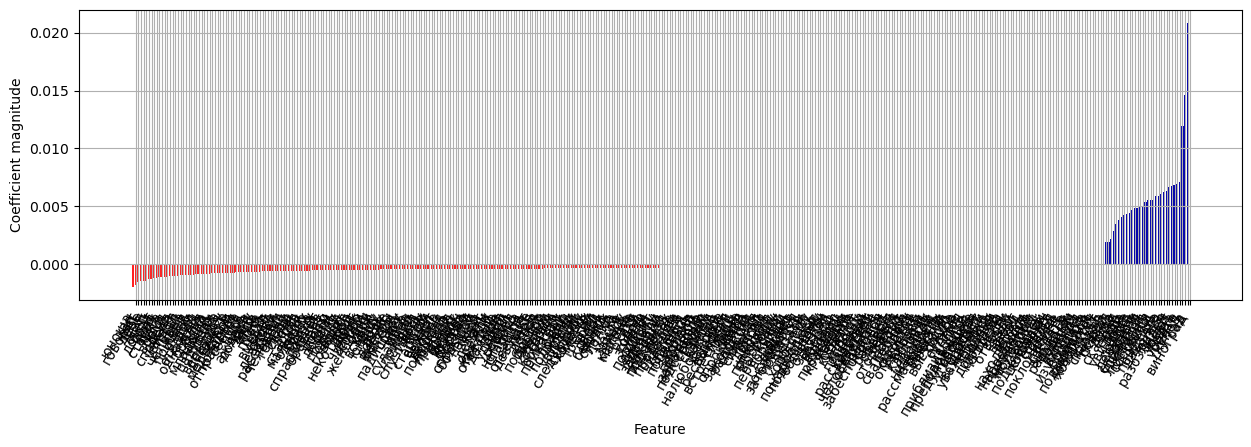

In [229]:
s_zahl = 200  #78 Anzahl der Merkmale, die in der Visualisierung dargestellt werden sollen

import matplotlib.pyplot as plt  
import mglearn

#79 Visualisieren der Koeffizienten des logistischen Regressionsmodells
mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_,  #80 Koeffizienten des Modells
    feature_names,  n_top_features=s_zahl  #81 Merkmalsnamen und Anzahl der Merkmale, die visualisiert werden sollen
)

#82 Anzeigen des Gitters in der Visualisierung
plt.grid()

#83 Anzeigen der Visualisierung
plt.show()
#plt.savefig(s_zahl+'.png', dpi=80)

In [230]:
#84 Extrahieren der Koeffizienten aus dem logistischen Regressionsmodell
gio = grid.best_estimator_.named_steps["logisticregression"].coef_[0]

#85 Sortieren der Indizes der Koeffizienten nach ihrer Größe
n_top = np.argsort(gio)

#86 Sortieren der Koeffizienten nach ihrer Größe
z_top = np.sort(gio)

#87 Extrahieren der Top-Merkmale mit den höchsten Koeffizienten
text_pos = feature_names[n_top[-s_zahl:]]
zahl_pos = gio[n_top[-s_zahl:]]

#88 Extrahieren der Top-Merkmale mit den niedrigsten Koeffizienten
text_neg = feature_names[n_top[0:s_zahl]]
zahl_neg = gio[n_top[0:s_zahl]]

#89 Ausgabe der positiven Merkmale und ihrer Koeffizienten
print("Positive Merkmale:\n{}".format(text_pos))

#90 Ausgabe der negativen Merkmale und ihrer Koeffizienten
# print("Negative Merkmale:\n{}".format(text_neg))

#91 Ausgabe der Koeffizienten der positiven Merkmale
# print("Positive coef:\n{}".format(zahl_pos))

#92 Ausgabe der Koeffizienten der negativen Merkmale
# print("Negative coef:\n{}".format(zahl_neg))

Positive Merkmale:
['заиграли' 'находил' 'подобная' 'избавить' 'лесах' 'проделав' 'отдадим'
 'извести' 'шея' 'нашелся' 'победить' 'смеясь' 'заходил' 'колена'
 'прошлой' 'западного' 'некоторые' 'подстрелил' 'старым' 'гриву' 'скажем'
 'какова' 'налюбоваться' 'шеи' 'ханское' 'выйдем' 'беспокойся' 'слугой'
 'встретилась' 'рабы' 'бане' 'опрокинул' 'живи' 'закончила' 'радостно'
 'спустил' 'забудь' 'сильная' 'бегал' 'долгий' 'бродя' 'накрыть'
 'поместил' 'миру' 'выброшу' 'саму' 'перескочил' 'добычей' 'вины' 'видано'
 'насчет' 'поклонился' 'заторопился' 'покинуть' 'резать' 'ом' 'престол'
 'хорошему' 'понадоблюсь' 'подземного' 'пал' 'больному' 'столы' 'ответом'
 'застрял' 'вперёд' 'немало' 'одолел' 'прежнему' 'красавиц' 'бедно'
 'женихи' 'седлай' 'купался' 'легче' 'играют' 'попрошу' 'звезды'
 'рассказывай' 'храбрый' 'хватает' 'человеческой' 'остальное' 'прыгать'
 'забеспокоился' 'собери' 'рассвет' 'вдвое' 'обещая' 'серый' 'оторвался'
 'пара' 'простит' 'свадебный' 'топора' 'духу' 'смеются' 'отве

In [231]:
kfz = range(s_zahl)  #93 Erstellen einer Sequenz von Zahlen von 0 bis s_zahl-1
folgenum = 0  #94 Initialisieren des Zählers für die Folgennummer

#95 Iteration über die Zahlen in der Sequenz kfz
for x in kfz:
    folgenum += 1  #96 Inkrementieren der Folgennummer
    #97 Berechnen der Summe der Koeffizienten für das aktuelle Element in der Liste
    vollliste = zahl_pos[s_zahl - folgenum] + zahl_neg[s_zahl - folgenum]
    #98 Runden der Summe auf drei Dezimalstellen
    rundliste = round(vollliste, 3)
    #99 Ausgabe der gerundeten Summe und der aktuellen Zahl in der Sequenz
    print(rundliste, '-', x)

0.02 - 0
0.014 - 1
0.012 - 2
0.007 - 3
0.007 - 4
0.006 - 5
0.006 - 6
0.006 - 7
0.006 - 8
0.006 - 9
0.006 - 10
0.006 - 11
0.006 - 12
0.005 - 13
0.005 - 14
0.005 - 15
0.005 - 16
0.005 - 17
0.005 - 18
0.005 - 19
0.004 - 20
0.004 - 21
0.004 - 22
0.004 - 23
0.004 - 24
0.004 - 25
0.003 - 26
0.003 - 27
0.002 - 28
0.002 - 29
0.002 - 30
0.002 - 31
-0.0 - 32
-0.0 - 33
-0.0 - 34
-0.0 - 35
-0.0 - 36
-0.0 - 37
-0.0 - 38
-0.0 - 39
-0.0 - 40
-0.0 - 41
-0.0 - 42
-0.0 - 43
-0.0 - 44
-0.0 - 45
-0.0 - 46
-0.0 - 47
-0.0 - 48
-0.0 - 49
-0.0 - 50
-0.0 - 51
-0.0 - 52
-0.0 - 53
-0.0 - 54
-0.0 - 55
-0.0 - 56
-0.0 - 57
-0.0 - 58
-0.0 - 59
-0.0 - 60
-0.0 - 61
-0.0 - 62
-0.0 - 63
-0.0 - 64
-0.0 - 65
-0.0 - 66
-0.0 - 67
-0.0 - 68
-0.0 - 69
-0.0 - 70
-0.0 - 71
-0.0 - 72
-0.0 - 73
-0.0 - 74
-0.0 - 75
-0.0 - 76
-0.0 - 77
-0.0 - 78
-0.0 - 79
-0.0 - 80
-0.0 - 81
-0.0 - 82
-0.0 - 83
-0.0 - 84
-0.0 - 85
-0.0 - 86
-0.0 - 87
-0.0 - 88
-0.0 - 89
-0.0 - 90
-0.0 - 91
-0.0 - 92
-0.0 - 93
-0.0 - 94
-0.0 - 95
-0.0 - 96
-0.0 - 97

In [233]:
#100 Schwelenwert bestimmen
sw = 31

In [234]:
filename ='!_neu'  #101 Der Dateiname für die CSV-Datei (ohne Erweiterung)
tit = (text_pos[s_zahl-sw:s_zahl])  #102 Die Titelzeile, die geschrieben werden soll

#103 Öffnen der CSV-Datei zum Schreiben ('wt' für Schreiben im Textmodus)
with open (filename+'.csv', 'wt', encoding='utf-8') as f:
    writer = csv.writer(f)  #85 Initialisieren des CSV-Schreibers
    writer.writerow(tit)  #86 Schreiben der Titelzeile in die CSV-Datei

# Messdaten aufbereiten

In [235]:
maerchen = ""  #101 Eine leere Zeichenkette, in der Daten für Märchen gesammelt werden.
import xml.etree.ElementTree as ET  #102 Importieren der ElementTree-Bibliothek zum Parsen von XML.
root_node = ET.parse('gesamt_märchen.xml').getroot()  #103 Parsen der XML-Datei und Zugriff auf das Wurzelelement.
never_saved = True  #104 Ein boolean-Wert, der angibt, ob Daten bereits gespeichert wurden oder nicht.
#105 Iteration durch jedes 'text'-Element in der XML-Datei.
for corp in root_node.findall (".//{http://www.tei-c.org/ns/1.0}teiCorpus"):
    if "xtk" in corp.attrib["n"]:
        for ganze in corp.findall(".//{http://www.tei-c.org/ns/1.0}text"):
            #106 Überprüfung, ob das Attribut 'deu' in der 'id'-Eigenschaft des 'text'-Elements vorhanden ist.
            if ('' in ganze.attrib['{http://www.w3.org/XML/1998/namespace}id']):
                #107 Iteration durch jeden Absatz im 'body' des 'text'-Elements.
                for body in ganze.findall(".//{http://www.tei-c.org/ns/1.0}body"):
                    for absatz in body.findall(".//{http://www.tei-c.org/ns/1.0}p"):
                        #108 Iteration durch jede 'seg'-Phrase im Absatz.
                        for phrase in absatz.findall(".//{http://www.tei-c.org/ns/1.0}seg"):
                            #109 Extrahieren von Labels und Inhalten aus den Attributen und dem Text der Phrase.
                            labela = phrase.attrib['{www.dglab.uni-jena.de/vmf/a}ana']
                            labelb1 = phrase.attrib['{www.dglab.uni-jena.de/vmf/b1}ana']
                            labelb2 = phrase.attrib['{www.dglab.uni-jena.de/vmf/b2}ana']
                            labelb3 = phrase.attrib['{www.dglab.uni-jena.de/vmf/b3}ana']
                            labelb4 = phrase.attrib['{www.dglab.uni-jena.de/vmf/b4}ana']
                            labelb5 = phrase.attrib['{www.dglab.uni-jena.de/vmf/b5}ana']
                            labelc1 = phrase.attrib['{www.dglab.uni-jena.de/vmf/c1}ana']
                            labelc2 = phrase.attrib['{www.dglab.uni-jena.de/vmf/c2}ana']
                            labelc3 = phrase.attrib['{www.dglab.uni-jena.de/vmf/c3}ana']
                            labelc4 = phrase.attrib['{www.dglab.uni-jena.de/vmf/c4}ana']
                            labelc5 = phrase.attrib['{www.dglab.uni-jena.de/vmf/c5}ana']
                            labeld = phrase.attrib['{www.dglab.uni-jena.de/vmf/d}ana']
                            #110 Die Quelle wird aus dem Attribut 'id' der 'ganze'-Schleife extrahiert.
                            quelle = ganze.attrib['{http://www.w3.org/XML/1998/namespace}id']
                            #111 Der Inhalt wird in Kleinbuchstaben umgewandelt und formatiert.
                            inhalt = (phrase.text.lower().strip().replace('|','').replace(':','').replace("ä","ae")
                                      .replace("ü","ue").replace("ö","oe").replace("ß","ss").replace(",","")
                                      .replace("«","").replace("»","").replace(".","").replace('=',' ').replace(";","")
                                      .replace('"',"").replace("?","").replace("!","").replace("á","a").replace(",","")
                                      .replace("\t"," ").replace("'","").replace("‹","").replace("›","").replace("-"," ")
                                      .replace("'('","").replace("')'","").replace('>','').replace("    "," ")
                                      .replace("   "," ").replace("  "," ").replace('–','').replace('—','').replace('<','')
                                      .replace("Â", "A").replace("ø", "oe").replace('“','').replace('„','').replace('(','')
                                      .replace(')','').replace('*','').replace("\n","\n")
                                      .replace("'''",""))
                            #112 Überprüfung, ob labela mit 'a' beginnt und nicht gleich 'N' ist.
                            if labelb1.startswith('N'):
                                    #113 Konstruktion des Datensatzes für das Märchen und Anhängen an die 'maerchen'-Zeichenkette.
                                    maerchen += (quelle+','+labela+','+labelb1+','+labelc1+','+labelb2+','+labelc2+','+
                                                 labelb3+','+labelc3+','+labelb4+','+labelc4+','+labelb5+','+labelc5+','+
                                                 labeld+','+inhalt+',0'+'\n')                       
with open("text.csv", 'w', encoding='utf-8') as f:
     #114 Schreiben der Kopfzeile in die CSV-Datei.
    f.write('quelle,labela,labelb1,labelc1,labelb2,labelc2,labelb3,labelc3,labelb4,labelc4,labelb5,labelc5,labeld,inhalt,index_binar')
    f.write('\n')
    #115 Schreiben der gesammelten Daten in die CSV-Datei.
    f.write(maerchen)

In [236]:
#118 Öffnen der CSV-Datei im Lesemodus und Lesen ihres Inhalts
with open(filename+'.csv', 'r', encoding='utf-8') as file:
    file_contents = file.read().replace(",", " ").replace("\n", "")  #119 Entfernen von Kommas und Zeilenumbrüchen

#120 Zusammenstellen des neuen Inhalts mit dem Dateinamen und zusätzlichen Metadaten
frt_contents = filename+',N,N,N,N,N,N,N,N,N,N,N,N'+','+file_contents+',0'

#121 Löschen der ursprünglichen CSV-Datei
import os 
os.remove(filename+'.csv')

In [237]:
row = [frt_contents]  #122 Erstellen einer neuen Zeile mit dem zusammengestellten Inhalt

#123 Öffnen der CSV-Datei im Lesemodus und Lesen der vorhandenen Zeilen
with open("text.csv", 'r', encoding='utf-8') as readFile:
    rd = csv.reader(readFile)  #124 Initialisieren des CSV-Lesers
    lines = list(rd)  #125 Lesen der Zeilen und Konvertieren in eine Liste

    #126 Einfügen der neuen Zeile an der zweiten Position in die Liste der Zeilen
    lines.insert(1, row)

#127 Öffnen der CSV-Datei im Schreibmodus und Schreiben der aktualisierten Zeilen
with open("text.csv", 'wt', newline='', encoding='utf-8') as writeFile:
    wt = csv.writer(writeFile)  #128 Initialisieren des CSV-Schreibers
    wt.writerows(lines)  #129 Schreiben der Zeilen in die Datei

#130 Öffnen der ursprünglichen und neuen CSV-Dateien zum Lesen bzw. Schreiben
fin = open('text.csv', 'r', encoding='utf-8')
fout = open('text_reich.csv', "wt", encoding='utf-8')

#131 Iteration über die Zeilen der ursprünglichen CSV-Datei
for kfz in fin:
    #132 Schreiben der Zeile in die neue Datei mit Entfernung bestimmter Zeichenfolgen
    fout.write(kfz.replace('"', ''))
#133 Schließen beider Dateien
fin.close()
fout.close()

In [238]:
#134 Funktion für die Beseitigung der leeren Datensätzen
def delete_records_with_empty_field(file_path, field_name):
    
    #135 Öffnen der CSV-Datei im Lese-Modus
    with open(file_path,  'r', encoding="utf-8") as file:
        #136 Lesen der Daten als Liste von Dictionaries
        reader = csv.DictReader(file)
        rows = list(reader)

    #137 Überprüfen, ob das Feld in den Daten leer ist
    filtered_rows = [row for row in rows if row[field_name]]

    #138 Öffnen der CSV-Datei im Schreibmodus und Schreiben der verbleibenden Datensätze
    with open(file_path, 'w', encoding="utf-8", newline='') as file:
        writer = csv.DictWriter(file, fieldnames=reader.fieldnames)
        writer.writeheader()
        writer.writerows(filtered_rows)

#139 Beispielaufruf der Funktion
file_path = 'text_reich.csv'  #140 Passe den Pfad zu deiner CSV-Datei an
field_name = 'inhalt'  #142 Passe den Namen des Feldes an, das überprüft werden soll
delete_records_with_empty_field(file_path, field_name)

In [239]:
t_corpus = []  #143 Eine leere Liste zum Speichern der Textdaten
df = pd.read_csv('text_reich.csv', encoding='utf-8')  #144 Einlesen der CSV-Datei in ein Pandas DataFrame
file = 'text_reich.csv'  #145 Der Dateiname der CSV-Datei

#146 Öffnen der CSV-Datei im Lesemodus und Extrahieren der Textdaten
with open(file, "rt", encoding='utf-8') as maerchen:
    maercho = df.inhalt  #147 Extrahieren der Spalte "inhalt" aus dem DataFrame
    reader = csv.reader(maercho)  #148 Initialisieren des CSV-Lesers
    for row in reader:
        lst = str(row)  #149 Konvertieren der gelesenen Zeile in eine Zeichenfolge
        t_corpus.append(lst)  #150 Hinzufügen der Zeichenfolge zur Liste der Textdaten

## Vorhersage durch Logistic Regression

In [240]:
# #151 Vorhersagen für die Testdaten mit dem trainierten Modell durchführen
# mod_pred = grid.predict(t_corpus)

# #152 Iteration über die Indizes und Vorhersagen
# for index, prediction in enumerate(mod_pred):
#     #153 Überprüfen, ob die Vorhersage positiv ist
#     if prediction == 1:
#         #154 Ausgabe des Index und der Vorhersage für positiv bewertete Datensätze
#         print('Positiv bewerteter Datensatz: {}'.format(index))

In [241]:
# #155 Vorhersagen für die Testdaten mit der Methode `predict_proba` durchführen
# all_pred = grid.predict_proba(t_corpus)

# #156 Sortieren der Indizes der Testdaten basierend auf der Wahrscheinlichkeit positiver Vorhersagen in absteigender Reihenfolge
# sort_index = np.flip(all_pred[:, 1].argsort())

# #157 Iteration über die sortierten Indizes der Testdaten
# for num_pos in sort_index:
#     #158 Extrahieren der Wahrscheinlichkeit der positiven Vorhersage für das aktuelle Datenpunkt
#     pos = all_pred[num_pos][1]
    
#     #159 Iteration über die Indizes und Datenpunkte der Testdaten
#     for i, t_corpus_element in enumerate(t_corpus):
#         #160 Überprüfen, ob der Index mit dem sortierten Index übereinstimmt und die Wahrscheinlichkeit hoch genug ist
#         if i == num_pos and num_pos >= 0 and pos >= 0.001:
#             #161 Ausgabe des Index, der Wahrscheinlichkeit, der Quelle, dem Inhalt und der Index-Binarisierung
#             print(num_pos, '-', pos, '-', df.quelle[num_pos], '-', df.inhalt[num_pos],
#                   '-', df.index_binar[num_pos], '\n')

## Vorhersage durch Cosine Similarity

In [242]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#162 Initialisieren des TF-IDF-Vektorisierers mit bestimmten Parametern
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1,1), 
                             min_df=2, stop_words=stpw)

#163 Erstellen des Vokabulars aus den Textdaten mit dem TF-IDF-Vektorisierer
vocabulary = vectorizer.fit_transform(t_corpus)

#164 Funktion zur Suche nach ähnlichen Dokumenten basierend auf der Kosinusähnlichkeitsmetrik
def find_similar(vocabulary, index, top_n=-1):
    #165 Berechnen der Kosinusähnlichkeitswerte zwischen dem ausgewählten Dokument und allen anderen Dokumenten
    similarities = cosine_similarity(vocabulary[index:index+1], vocabulary).flatten()
    #166 Sortieren der Dokumente basierend auf den Kosinusähnlichkeitswerten in absteigender Reihenfolge
    related_docs_indices = [i for i in similarities.argsort()[::-1] if i != index]
    #167 Auswahl der Top-n ähnlichsten Dokumente und Rückgabe ihrer Indizes und Kosinusähnlichkeitswerte
    return [(index, similarities[index]) for index in related_docs_indices][:top_n]

#168 Die TF-IDF-Vektoren für die Textdaten können über `vocabulary` abgerufen werden
# print(vocabulary)

In [243]:
n_te = 0  #169 Index des ersten Dokuments
inhalt = df.inhalt[n_te]
print(inhalt)  #170 Ausgabe des Inhalts des ersten Dokuments

#with open(gesep_1.replace(':','')+'.txt','w', encoding="utf-8") as file:
    #file.write(inhalt)

пошел сказал дома туда сказали сюда иди увидела доме позвал девушка пойти спросили удивился платок поставил собрался убили пойдешь давайте это купца разозлился знаем убьют сада брать убейте купец сад виноград


In [244]:
# 171 Iteration über die ähnlichen Dokumente zum ersten Dokument
for index, score in (find_similar(vocabulary, n_te)):
    #172 Überprüfen, ob die Ähnlichkeit größer als 0.1 ist
    if score > 0.1:
        #173 Ausgabe des Index, der Ähnlichkeit, der Quelle und des Inhalts des ähnlichen Dokuments
        print(index, '-', score, '-', df.quelle[index], '-', t_corpus[index], '\n')

11850 - 0.19594029715251224 - zyx_cr_ttt_rus_30 - ['купец удивился и говорил'] 

13487 - 0.19039907553954177 - zyx_cr_ttt_rus_49 - ['купец сказал'] 

7385 - 0.18675367427644887 - zyx_cr_lez_rus_12 - ['нет сказали все родственники купца так нельзя давайте мы его отправим к падишаху'] 

11820 - 0.1704953063678666 - zyx_cr_ttt_rus_30 - [' эй ты пойдешь ко мне работать  спрашивает купец'] 

2070 - 0.15902079463700275 - zyx_cr_dar_rus_113 - [' чем чистить тебя лучше вот так раскачиваться на ветру туда и сюда туда и сюда'] 

2353 - 0.15666515439494738 - zyx_cr_dar_rus_137 - [' дома это делают моя жена и его мать поэтому мы не знаем как это делается'] 

7390 - 0.1559541380357747 - zyx_cr_lez_rus_12 - ['вы сказала девушка вместо него убейте зайца испачкайте его одежду кровью'] 

2418 - 0.15563505987612106 - zyx_cr_dar_rus_138 - [' а что ои может сделать  удивился купец'] 

7195 - 0.1507554268801219 - zyx_cr_lbe_rus_8 - ['жене купец сказал'] 

8652 - 0.14992795151716135 - zyx_cr_nog_rus_25 - ['